# Pipeline de Dados - Bot Telegram API

GitHub: [Repositório](https://github.com/hellen-peixoto-mattos/Pipeline-de-Dados.git).

Autor: Hellen Peixoto.



------------

## 0. Introdução

Este projeto tem como objetivo desenvolver um pipeline de dados eficiente para coletar informações dos chats de um grupo no **Telegram**, processá-las por meio de um fluxo **ETL** (*Extração, Transformação e Carga*) e, por fim, disponibilizar os dados transformados e normalizados.


O **Telegram** atua como a principal fonte transacional de dados do **pipeline**. Nesta etapa, criamos um grupo, configuramos um bot e o adicionamos ao grupo recém-criado. Esse bot é responsável por capturar todas as mensagens enviadas no chat, permitindo o acesso às informações por meio da **API** de bots do **Telegram**.

* **Apresentação da arquitetura:**

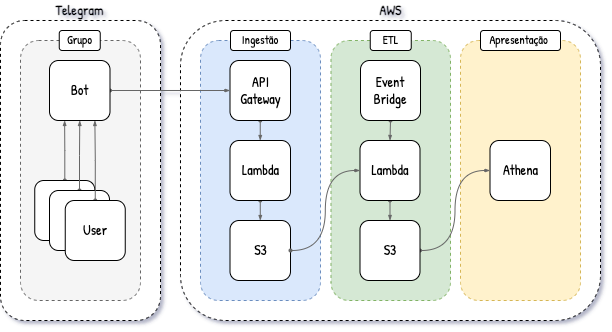

## 1. Telegram

### Bot API

As mensagens captadas por um bot podem ser acessadas via API. A
única informação necessária é o `token` de acesso fornecido pelo
`BotFather` na criação do bot.

No **Telegram**, seguiremos o seguinte passo a passo:

1. Criar um **bot** utilizando o **BotFather**.

2. Criar um grupo e adicionar o **bot** recém-criado como administrador.

3. Acessar o **BotFather** novamente e configurar a opção **Allow Groups** como **Turn Groups Off**, garantindo que o **bot** não seja adicionado a outros grupos, proporcionando maior controle e consistência.





Com isso, todas as mensagens enviadas pelos membros do grupo serão capturadas pelo bot automaticamente.

## 2. Ingestão

A etapa de ingestão é responsável por capturar e armazenar os dados, mantendo-os no formato mais próximo do original. Em geral, os dados ingeridos são persistidos sem transformações em seu conteúdo ou estrutura. Um exemplo comum são dados provenientes de uma API web baseada no padrão REST (*Representational State Transfer*), que são entregues e armazenados no formato `JSON`.

Para viabilizar esse processo de ingestão, utilizaremos um **webhook** (*gancho web*), que permitirá o redirecionamento automático das mensagens para outra API web. Para isso, configuraremos o `AWS API Gateway`, que, entre suas diversas funcionalidades, possibilita o encaminhamento dos dados recebidos para outros serviços da AWS.

Dessa forma, conectaremos o API Gateway ao `AWS Lambda`, que será responsável por armazenar os dados em seu formato original (`JSON`) em um bucket do `AWS S3`.



> A documentação pode ser encontrada neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html).

### AWS S3

O bucket criado no S3 armazenará os dados em seu formato original,
utilizando a nomenclatura `datalake-raw`.

image.png

> **Nota:**
>
>* Raw pois o dados está de fato 'cru', sem nenhum tipo de tratamento.
>
> * Data Lake é o nome dado a um repositório que armazena grandes volumes de dados. Ele é estruturado em zonas, onde os dados são replicados em diferentes níveis de processamento.

### Lambda

O `AWS Lambda` será responsável por armazenar, de forma automatizada, as mensagens capturadas pelo bot do **Telegram** em um bucket do `AWS S3`. Para garantir o funcionamento dessa etapa, seguiremos o seguinte processo:

* **Criação da função Lambda:**

 * **Recebimento da mensagem:** A função será acionada ao receber uma solicitação contendo a mensagem no parâmetro `event`.
 * **Validação da origem:** Para garantir que apenas mensagens enviadas no grupo correto do **Telegram** sejam processadas, implementaremos uma validação que impedirá a captura de mensagens privadas enviadas ao bot.
 * **Armazenamento dos dados:** As mensagens serão persistidas no `AWS S3` no formato `JSON`, mantendo sua estrutura original.
 * **Confirmação da operação:** A função retornará uma resposta de sucesso *(HTTP 200)* para a API de bots do **Telegram**, confirmando o armazenamento bem-sucedido.

* **Configuração de variáveis de ambiente:**
Definiremos duas variáveis de ambiente essenciais para o funcionamento da automação.

 * **AWS_S3_BUCKET** → Nome do bucket onde os dados brutos serão armazenados.
 * **TELEGRAM_CHAT_ID** → Identificador único do grupo no **Telegram** que o bot está monitorando.

* **Permissões do AWS Lambda:**

Por fim, garantiremos que a função Lambda tenha as permissões adequadas para escrita no bucket do `AWS S3`, permitindo que os dados sejam armazenados corretamente.



-----

* **Variáveis de Ambiente:**

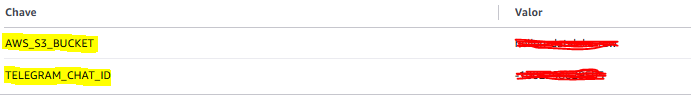

* **Permissões:**

Por questões de segurança, configurei o `AWS Lambda` para ter permissão exclusiva de escrita em um bucket específico. Abaixo está o código `JSON` utilizado para restringir o acesso apenas à escrita nesse bucket:

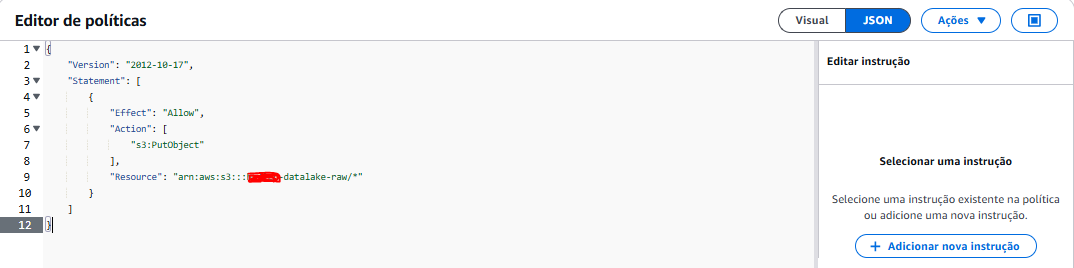

### API Gateway

Na etapa de **ingestão**, o `AWS API Gateway` tem o papel de receber as mensagens captadas pelo bot do **Telegram**, enviadas via webhook, e acionar uma função do `AWS Lambda`, passando o conteúdo da mensagem no parâmetro `event`.

Para configurar essa integração, seguiremos os passos abaixo:
1. **Criar a API:** Acessar o `AWS API Gateway` e criar uma `REST API`.
2. **Configurar o método HTTP:** Definir o método `POST` para receber as mensagens.
3. **Ativar a integração com o Lambda:** Habilitar a opção Use `Lambda Proxy Integration`.
4. **Vincular a função Lambda:** Associar a API à função Lambda criada anteriormente.
5. **Publicar a API**: Realizar o deploy acessando `Deploy Actions` → `Deploy API`.

Com essa configuração, o `API Gateway` atuará como intermediário, encaminhando as mensagens do **Telegram** para a função Lambda, garantindo um fluxo eficiente de ingestão de dados.

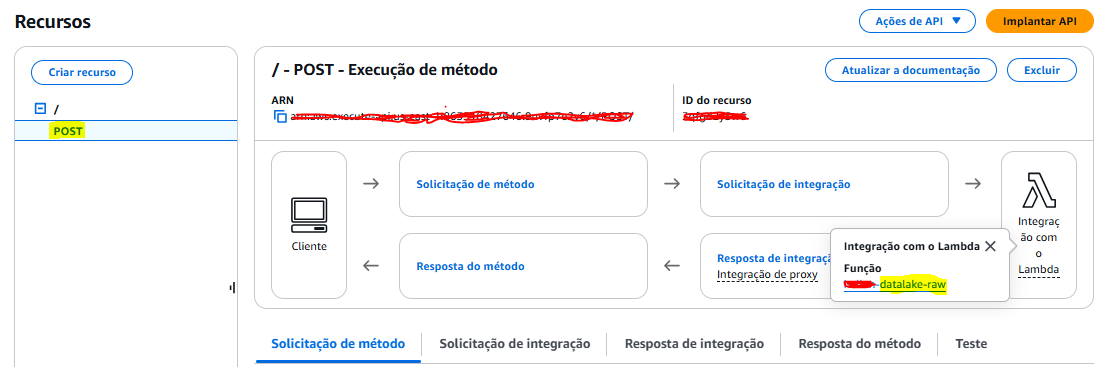

Ao final do processo, será gerada uma `URL`, que será utilizada para configurar o webhook e redirecionar as mensagens para esse endereço. O método `setWebhook` define esse redirecionamento, enviando as mensagens captadas pelo bot para a `URL` especificada no parâmetro.

> **Nota:** Enquanto o webhook estiver ativo, o método `getUpdates` não funcionará. Para desativar o webhook, basta utilizar o método `deleteWebhook`.

Entrada:
```
aws_api_gateway_url = 'url da API que criamos com o AWS API Gateway'
response = requests.get(url=f'{url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))
```
Saída:
```
{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}
```

## ETL

A etapa de **Extração**, **Transformação** e **Carga** *(Extraction, Transformation and Load – **ETL**)* é responsável pelo processamento dos dados ingeridos a partir de sistemas transacionais. Esses dados já foram persistidos na camada raw *(crua)* de um sistema analítico, sem modificações.


Os processos conduzidos nessa etapa variam conforme a área da empresa, o volume, a variedade e a velocidade dos dados consumidos. No entanto, de forma geral, os dados brutos passam por um processo recorrente de **data wrangling**, que inclui limpeza, deduplicação e estruturação. Após esse tratamento, os dados são armazenados utilizando técnicas de **particionamento**, **orientação a colunas** e **compressão**, tornando-os mais eficientes para análise.

No nosso projeto, as mensagens capturadas ao longo de um dia, armazenadas na camada raw, serão compactadas em um único arquivo, utilizando um formato colunar e comprimido. Esse arquivo será então persistido em uma camada enriquecida para facilitar consultas e análises. Durante esse processo, os dados passarão por etapas de **data wrangling** para garantir qualidade e padronização.
  * **AWS Lambda:** Atuará como o motor de processamento para transformar os dados.
  * **AWS S3:** Servirá como repositório da camada enriquecida, armazenando os dados processados.
  * **AWS EventBridge:** Será configurado para acionar a função Lambda diariamente, garantindo a recorrência do processamento.

### AWS S3


Nessa etapa, criaremos um bucket no `AWS S3`, onde ele terá a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato `Parquet`, tendo em vista que é um ótimo formato para otimizar o armazenamento das informações no `S3`.

image.png

> **Nota:** O sufixo `-enriched` indica que os dados pertencem a uma camada intermediária, onde já foram submetidos a processos de transformação, limpeza e enriquecimento, tornando-os mais estruturados e prontos para análise.

###AWS Lambda

Nesta etapa, o `AWS Lambda` será responsável por ler as mensagens armazenadas na camada raw *(crua)* do `AWS S3`, realizar o data wrangling e persistir os dados transformados na camada enriched *(enriquecida)* dentro de um novo bucket do `AWS S3`. Siga o passo a passo:

1. **Criação da Função Lambda:**
* **Para cada arquivo listado:**
  * Fazer o download e carregar o conteúdo das mensagens.
  * Executar o processo de data wrangling (**limpeza**, **deduplicação** e **enriquecimento dos dados**).
  * Criar uma tabela PyArrow e concatená-la com os demais dados processados.
  * Persistir a tabela no formato `Parquet` na camada enriched do bucket do `AWS S3`.

2. **Configuração de Variáveis de Ambiente:**

  * **RAW_BUCKET** → Nome do bucket criado na etapa de ingestão, onde os dados brutos são armazenados *(camada raw)*.
  * **ENRICHED_BUCKET** → Nome do bucket recém-criado, onde os dados processados serão armazenados *(camada enriched)*.

3. **Permissões Necessárias:**
  * Leitura no bucket raw (para acessar os dados brutos).
  * Escrita no bucket enriched (para armazenar os dados processados).
  * Listagem do conteúdo no bucket raw (para consultar quais arquivos estão disponíveis).

4. **Criação de uma Layer para PyArrow:**

Como a biblioteca PyArrow não está incluída no ambiente padrão do `AWS Lambda`, será necessário criar uma layer e adicioná-la à função, permitindo a manipulação eficiente dos dados.

-----

* **Variáveis de ambiente**

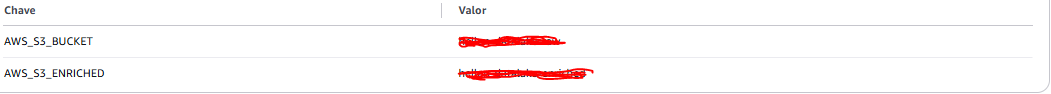

* **Permissões**

Para evitar falhas, é essencial que o Lambda possua permissões de leitura e listagem no bucket de dados brutos. Portanto, adicionaremos novamente permissões personalizadas ao `AWS Lambda` para que ele possa acessar e processar os dados armazenados no bucket raw. Dessa vez, além da permissão de escrita no bucket enriched, precisaremos de duas permissões adicionais no bucket raw:

1. **Permissão de leitura (`s3:GetObject`)** → Necessária para que o Lambda acesse os dados brutos e realize a normalização.
2. **Permissão de listagem (`s3:ListBucket`)** → Essencial para que o Lambda consiga listar os arquivos armazenados no bucket raw.



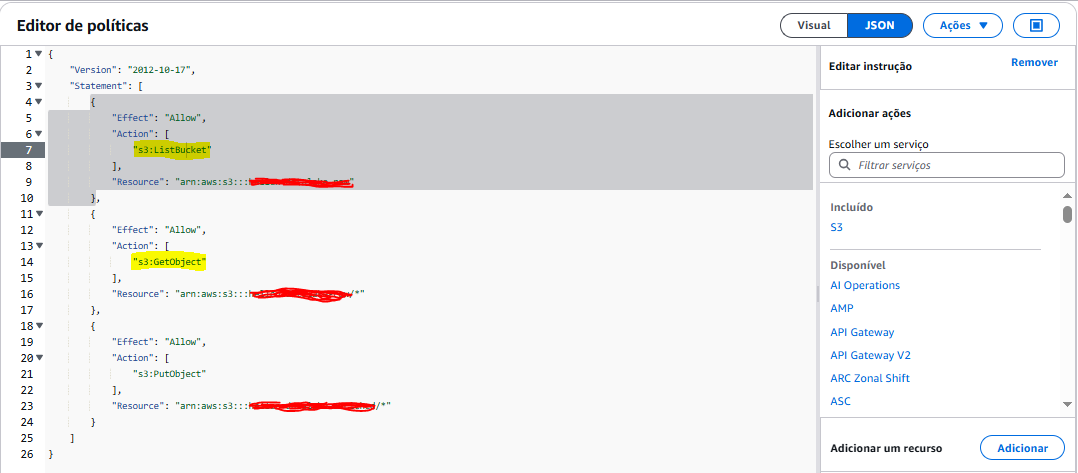

* **Camadas**

Por fim, observe que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` inclui apenas alguns pacotes externos, como o `boto3`, e, portanto, o PyArrow não estará disponível, o que resultará na falha da execução da função. Para resolver esse problema, adicionaremos uma layer ao nosso Lambda. Como estou utilizando o Python 3.9, utilizarei uma layer compatível com essa versão.

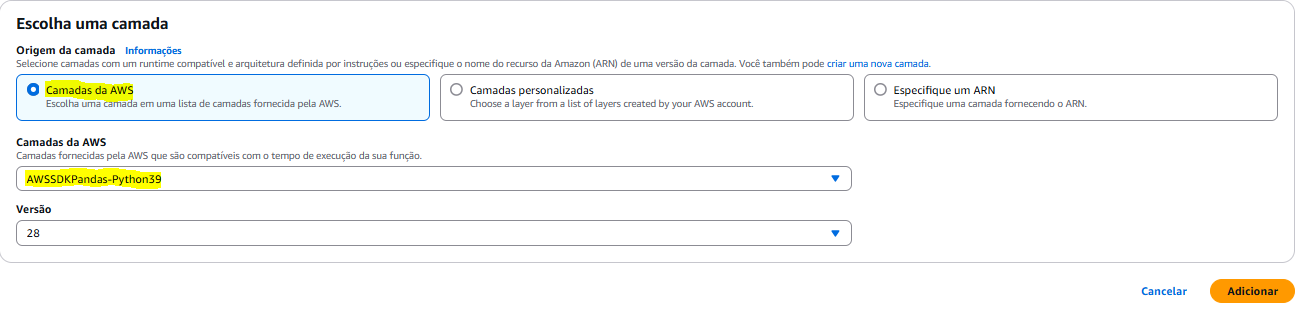

## AWS Event Bridge

O `AWS EventBridge` acionará diariamente a função de **ETL** do AWS Lambda, funcionando como um scheduler que processa os dados referentes ao dia anterior (D-1).

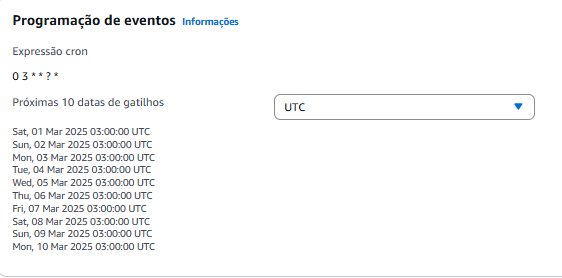

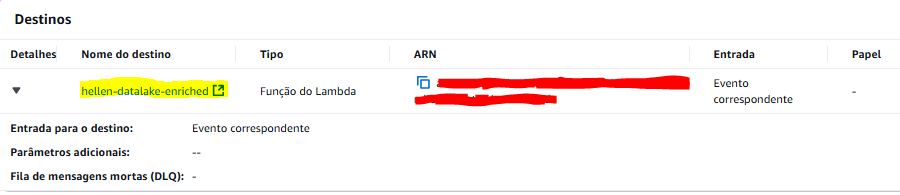

## AWS Athena *(Apresentação)*

Na etapa de apresentação, os dados serão disponibilizados aos usuários do sistema analítico por meio de uma interface `SQL` do `AWS Athena`. Para isso, basta criar uma tabela externa sobre os dados armazenados na camada mais refinada da arquitetura, a camada enriquecida.


---------

Sempre que uma nova partição for adicionada precisaremos executar o código abaixo:

```
MSCK REPAIR TABLE "telegram";
```

Consulta ordenadas para observar o resultado:

```
SELECT * FROM "telegram" ORDER BY message_id;
```

Saída:

In [7]:
import pandas as pd

consulta = pd.read_csv('SQL-message.csv')
consulta

,message_id,user_id,user_is_bot,user_first_name,chat_id,chat_type,text,date,context_date
0,25,6428177482,False,hellen,-1002298629595,supergroup,Teste,1739032081,2025-02-08
1,25,6428177482,False,hellen,-1002298629595,supergroup,Teste,1739032081,2025-02-08


Quantidade de mensagens para cada data, exibindo as datas mais recentes:

```
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

Saída:

In [ ]:
pd.read_csv('qtd_message.csv')

,context_date,message_amount
0,2025-02-08,2


Quantidade de mensagens enviadas para cada usuário e cada data, filtradas com as datas mais recentes:

```
SELECT
  user_id,
  user_first_name,
  context_date,
count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

Saída:

In [ ]:
pd.read_csv('qtd_message_usuario.csv')

,user_id,user_first_name,context_date,message_amount
0,6428177482,hellen,2025-02-08,2


Essa consulta extrai informações temporais relevantes – como a hora, o dia da semana e a semana do ano – e agrupa as mensagens com base nesses atributos, contando-as para identificar padrões de atividade ao longo do tempo.

```
WITH parsed_date_cte AS (
  SELECT
      *,
      CAST(
          date_format(from_unixtime("date"), '%Y-%m-%d %H:%i:%s') AS timestamp
      ) AS parsed_date
  FROM "telegram"
),

hour_week_cte AS (
  SELECT
      *,
      EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
      EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
      EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
  FROM parsed_date_cte
)

SELECT
  parsed_date_hour,
  parsed_date_weekday,
  parsed_date_weeknum,
  COUNT(1) AS message_amount
FROM hour_week_cte
GROUP BY
  parsed_date_hour,
  parsed_date_weekday,
  parsed_date_weeknum
ORDER BY
  parsed_date_weeknum,
  parsed_date_weekday;
```  

Saída:

In [ ]:
pd.read_csv('qtd_message_hora_ semana.csv')

,parsed_date_hour,parsed_date_weekday,parsed_date_weeknum,message_amount
0,16,6,6,2


essa consulta retorna, para cada usuário e para cada data, o comprimento médio das mensagens enviadas, facilitando a análise do engajamento dos usuários ao longo do tempo.

```
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

Saída:

In [ ]:
pd.read_csv('media_tam_menssage_usuario_dia.csv')

,user_id,user_first_name,context_date,average_message_length
0,6428177482,hellen,2025-02-08,5
